In [1]:
!pip install scikit-surprise

In [2]:
import pandas as pd; import surprise;

In [3]:
raw_data = pd.read_csv('../Ratings/ratings.csv')
raw_data.drop_duplicates(inplace=True)
raw_data.head()

,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
3,1,1221,5.0,1425941546
4,1,1246,5.0,1425941556


In [4]:
raw_data.describe()

,userId,movieId,rating,timestamp
count,2.602429e+07,2.602429e+07,2.602429e+07,2.602429e+07
mean,1.350371e+05,1.584911e+04,3.528090e+00,1.171258e+09
std,7.817620e+04,3.108526e+04,1.065443e+00,2.052889e+08
min,1.000000e+00,1.000000e+00,5.000000e-01,7.896520e+08
25%,6.716400e+04,1.073000e+03,3.000000e+00,9.907545e+08
50%,1.351630e+05,2.583000e+03,3.500000e+00,1.151716e+09
75%,2.026930e+05,6.503000e+03,4.000000e+00,1.357578e+09
max,2.708960e+05,1.762750e+05,5.000000e+00,1.501830e+09


In [5]:
raw_data = raw_data[['userId', 'movieId', 'rating']]
rating_col = raw_data['rating']
reader = surprise.Reader(rating_scale=(rating_col.min(),rating_col.max()))
data = surprise.Dataset.load_from_df(raw_data, reader)

In [6]:
import numpy as np 
#source https://www.kaggle.com/robottums/probabalistic-matrix-factorization-with-suprise
class ProbabilisticMatrixFactorization(surprise.AlgoBase):
    # Randomly initializes two Matrices, Stochastic Gradient Descent to be able to optimize the best factorization for ratings.
    def __init__(self,learning_rate,num_epochs,num_factors):
       # super(surprise.AlgoBase)
        self.alpha = learning_rate #learning rate for Stochastic Gradient Descent
        self.num_epochs = num_epochs
        self.num_factors = num_factors
    def fit(self,train):
        #randomly initialize user/item factors from a Gaussian
        P = np.random.normal(0,.1,(train.n_users,self.num_factors))
        Q = np.random.normal(0,.1,(train.n_items,self.num_factors))
        #print('fit')

        for epoch in range(self.num_epochs):
            for u,i,r_ui in train.all_ratings():
                residual = r_ui - np.dot(P[u],Q[i])
                temp = P[u,:] # we want to update them at the same time, so we make a temporary variable. 
                P[u,:] +=  self.alpha * residual * Q[i]
                Q[i,:] +=  self.alpha * residual * temp 

                
        self.P = P
        self.Q = Q

        self.trainset = train
    
    
    def estimate(self,u,i):
        #returns estimated rating for user u and item i. Prerequisite: Algorithm must be fit to training set.
        #check to see if u and i are in the train set:
        #print('gahh')

        if self.trainset.knows_user(u) and self.trainset.knows_item(i):
            #print(u,i, '\n','yep:', self.P[u],self.Q[i])
            #return scalar product of P[u] and Q[i]
            nanCheck = np.dot(self.P[u],self.Q[i])
            
            if np.isnan(nanCheck):
                return self.trainset.global_mean
            else:
                return np.dot(self.P[u,:],self.Q[i,:])
        else:# if its not known we'll return the general average. 
           # print('global mean')
            return self.trainset.global_mean
                
        

In [8]:
gs = surprise.model_selection.cross_validate(ProbabilisticMatrixFactorization(learning_rate=0.5, num_epochs=5, num_factors=10), data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
print(gs)

Evaluating RMSE, MAE of algorithm ProbabilisticMatrixFactorization on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0654  1.0653  1.0656  1.0654  1.0655  1.0654  0.0001  
MAE (testset)     0.8472  0.8470  0.8474  0.8471  0.8473  0.8472  0.0001  
Fit time          1149.24 1184.95 1183.44 1170.63 1166.58 1170.97 12.98   
Test time         200.96  156.21  155.01  203.77  156.94  174.58  22.71   
{'test_rmse': array([1.06538118, 1.06528224, 1.06560798, 1.06539281, 1.06554973]), 'test_mae': array([0.84721602, 0.8470434 , 0.84736663, 0.84707785, 0.84731165]), 'fit_time': (1149.2418768405914, 1184.9547774791718, 1183.442004442215, 1170.6263451576233, 1166.579116344452), 'test_time': (200.95586729049683, 156.20855402946472, 155.0126452445984, 203.76505136489868, 156.9418911933899)}


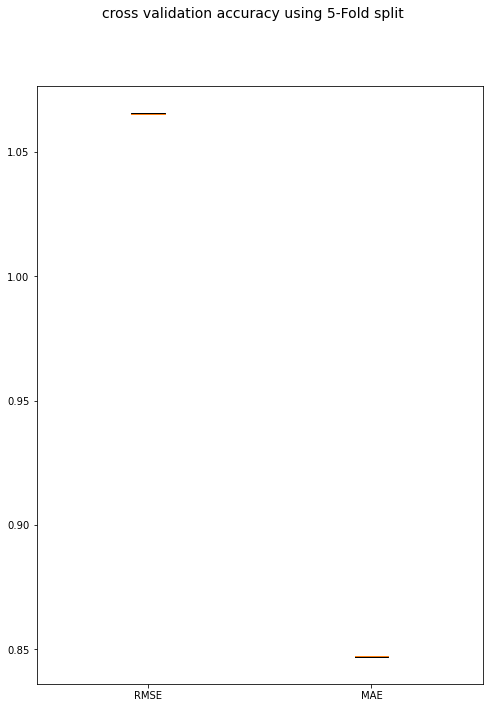

In [13]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12, 8))
fig.suptitle('cross validation accuracy using 5-Fold split', fontsize=14)
ax = fig.add_subplot(111)
plt.boxplot([gs['test_rmse'], gs['test_mae']])
ax.set_xticklabels(['RMSE', 'MAE'])
plt.show();